In [1]:
from IPython.display import clear_output 
# !pip install nmslib spacy tqdm
# !python -m spacy download en_core_web_md
clear_output()

# Generate some vectors 

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Read it as CSV. Embed `Question`s with spacy model.

In [2]:
MAX = 30000
DATASET_FILENAME = '../datasets/JEOPARDY_CSV.csv'

In [3]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)

In [4]:
import spacy
import tqdm
import pickle
import os

nlp = spacy.load('en_core_web_md')
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
else:
    for i, line in enumerate(tqdm.tqdm(strings)):
        emb = nlp(line['Question'])
        vectors[i, :] = emb.vector
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)

In [5]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [25]:
import nmslib

def get_index(
        vectors, 
        method='hnsw', 
        space='cosinesimil', 
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()
    
    if cutoff is not None:
        vectors = vectors[:cutoff]
    
    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        # this parameter appies to HNSW only
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index


# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    # TODO your code here
    return list(index.knnQuery(vector, k=nn)[0])

# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    # TODO your code here
    return [ list(x) for x,_ in index.knnQueryBatch(batch, k=nn) ]

## Construct buckets with ground truth

In [26]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra', 
          'cooking', 'armory', 'war', 'history', 'money', 'books', 
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry', 'stars', 'science fiction',
          'languages', 'clothes']
bucket_vectors = [nlp(t).vector for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect real nearst neighbours with flat index (no index)

In [27]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [28]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [29]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [35]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # print(sorted_result)
    return len(set(sorted_result) & set(sorted_ground_truth[:N])) / N

In [36]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Disciss the values.
- Why do you see these numbers? 
- Why are they equal?

# Test HNSW

Create an index with default settings and assess its recall numbers.

In [37]:
hnsw = get_index(vectors, method='hnsw')


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

In [38]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@100 = 0.62
recall@1000 = 0.191
recall@2000 = 0.0955


Why recall drops with the growth of N?

In [39]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

# Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [40]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()
    
    # todo write here the code to construct index object given provided hyperparameters
    I = get_index(vectors=vectors[:D], M=M, efConstruction=ef, efSearch=ef)
    
    build_time = time.time() - start
    
    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.
    
    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)
    
    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results) 
    
    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

  0%|          | 0/60 [00:00<?, ?it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
  2%|▏         | 1/60 [00:00<00:29,  2.03it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
  3%|▎         | 2/60 [00:00<00:27,  2.10it/s]*****
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
*********

In [41]:
import pandas as pd
headers = ["M", "D", "ef", "built_time", "search 100", "search 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
df.to_pickle('results.pkl')
df

,M,D,ef,built_time,search 100,search 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,0.275990,0.024058,0.049379,0.878765,0.308527,0.878765
1,8,2000,200,0.253112,0.021794,0.051086,0.879380,0.312918,0.879380
2,8,2000,400,0.243794,0.025032,0.052535,0.878400,0.309659,0.878400
3,8,5000,100,0.394144,0.043463,0.082247,0.842790,0.321971,0.842790
4,8,5000,200,0.442489,0.039281,0.080519,0.842370,0.323954,0.842370
5,8,5000,400,0.420462,0.046111,0.110954,0.842830,0.324521,0.842830
6,8,10000,100,0.692557,0.039190,0.088750,0.812575,0.314785,0.812575
7,8,10000,200,0.699475,0.031535,0.087030,0.812715,0.313437,0.812715
8,8,10000,400,0.700662,0.049265,0.090874,0.812325,0.314177,0.812325
9,8,20000,100,1.665286,0.034466,0.089218,0.787270,0.304905,0.787270


Discuss, how parameters (using the table) affect perfromance?

## Load results.

(for some reason `pyplot` does not survive together with `nmslib` in Windows. So we save and load)

Lets display them now!

Discuss the graphs.

In [42]:
import pandas as pd
headers = ["M", "D", "ef", "built_time", "search 100", "search 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
df = pd.read_pickle('results.pkl')

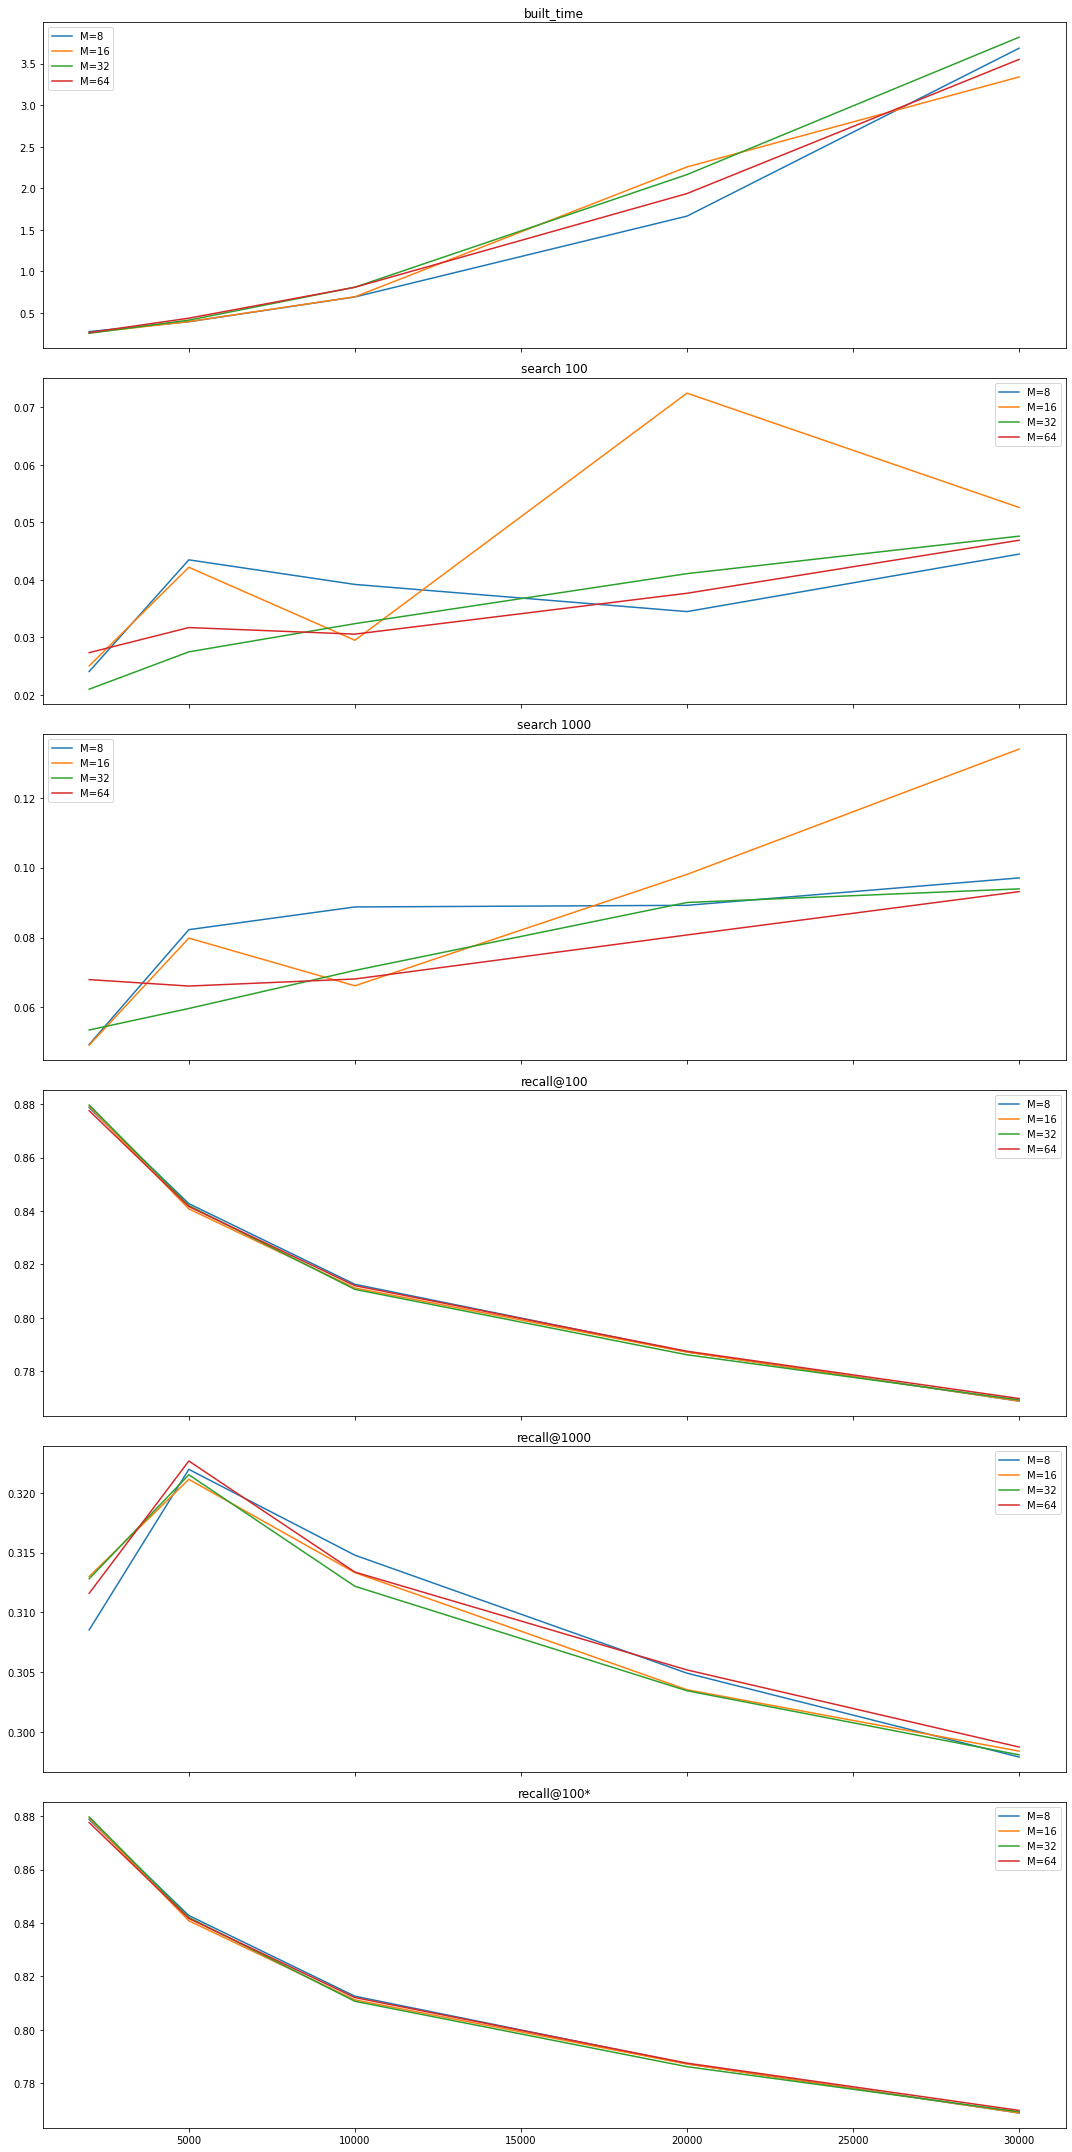

In [44]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, sharex=True, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()
        
plt.tight_layout()
plt.show()